In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Asos-Machine-learning').getOrCreate()
df = spark.read.csv('banking.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- deposit: integer (nullable = true)



### O datasete
Súbor údajov obsahuje podrobnosti o demografii zákazníkov (vek, pohlavie, telefónne číslo atď.). Údaj deposit je ten, ktorý budeme predpovedať. Potrebujeme vedieť s akým datasetom pracujeme, či obsahuje nejaké nevalidné dáta, nulové hodnoty, či ide o vyvážený alebo nevyvážený dataset. Nutná je teda kontrola dát a ich spracovanie.

In [3]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,44,53,28,39,55
job,blue-collar,technician,management,services,retired
marital,married,married,single,married,married
education,basic.4y,unknown,university.degree,high.school,basic.4y
default,unknown,no,no,no,no
housing,yes,no,yes,no,yes
loan,no,no,no,no,no
contact,cellular,cellular,cellular,cellular,cellular
month,aug,nov,jun,apr,aug
day_of_week,thu,fri,thu,fri,fri


In [ ]:
Všimli sme si, že chýba viac ako 8000 neplatičov

In [35]:
df.groupBy('default').count().toPandas()

,default,count
0,unknown,8597
1,no,32588
2,yes,3


### Naše triedy v datasete sú nevyvážené

In [4]:
df.groupby('deposit').count().toPandas()

,deposit,count
0,1,4640
1,0,36548


In [ ]:
#Hľadanie outliers (odľahlé hodnoty)

array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='duration', ylabel='age'>,
        <AxesSubplot:xlabel='campaign', ylabel='age'>,
        <AxesSubplot:xlabel='pdays', ylabel='age'>,
        <AxesSubplot:xlabel='previous', ylabel='age'>,
        <AxesSubplot:xlabel='deposit', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='duration'>,
        <AxesSubplot:xlabel='duration', ylabel='duration'>,
        <AxesSubplot:xlabel='campaign', ylabel='duration'>,
        <AxesSubplot:xlabel='pdays', ylabel='duration'>,
        <AxesSubplot:xlabel='previous', ylabel='duration'>,
        <AxesSubplot:xlabel='deposit', ylabel='duration'>],
       [<AxesSubplot:xlabel='age', ylabel='campaign'>,
        <AxesSubplot:xlabel='duration', ylabel='campaign'>,
        <AxesSubplot:xlabel='campaign', ylabel='campaign'>,
        <AxesSubplot:xlabel='pdays', ylabel='campaign'>,
        <AxesSubplot:xlabel='previous', ylabel='campaign'>,
        <AxesSubplot:xlabel='depos

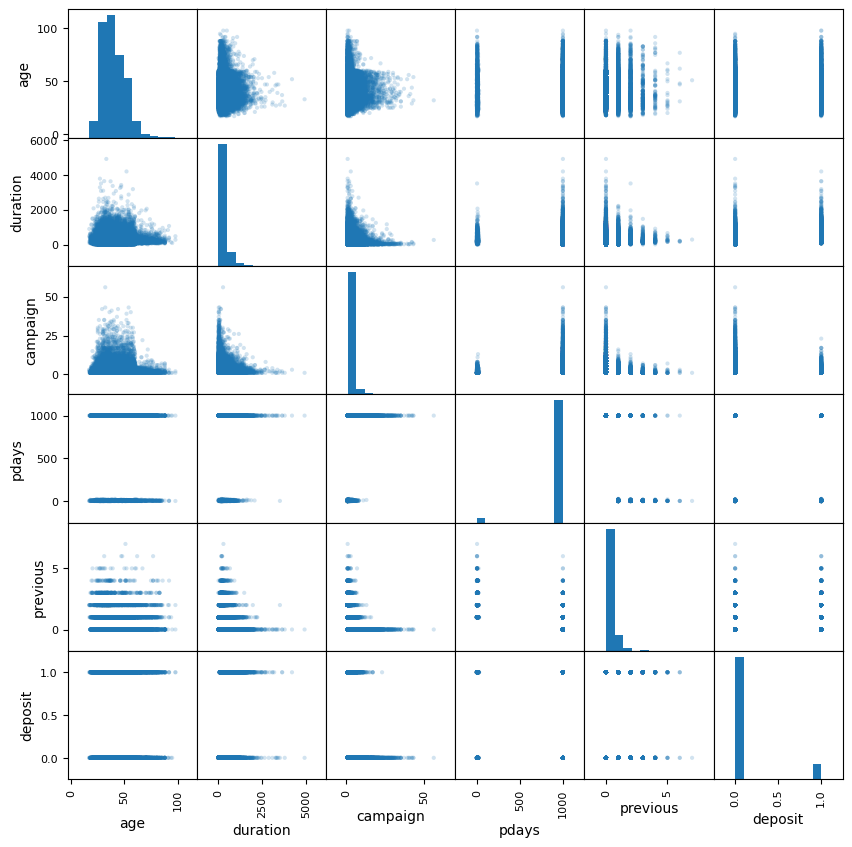

In [39]:
num = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(num).describe().toPandas().transpose()
numeric_data = df.select(num).toPandas()

pd.plotting.scatter_matrix(numeric_data, alpha=0.2,
                          grid=False, diagonal='hist', marker='.',
                          range_padding = 0.5,
                          figsize= (10,10))

### Súhrnné štatistiky pre číselné hodnoty

In [5]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,41188,40.02406040594348,10.421249980934075,17,98
duration,41188,258.2850101971448,259.27924883646574,0,4918
campaign,41188,2.567592502670681,2.7700135429023436,1,56
pdays,41188,962.4754540157328,186.91090734474133,0,999
previous,41188,0.17296299893172767,0.49490107983929066,0,7
deposit,41188,0.11265417111780131,0.31617342694296513,0,1


In [8]:
df = df.select('age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: integer (nullable = true)



### Príprava dát pre Machine Learning

Počítače sú navrhnuté tak, aby zvládli číslice ako 0 a 1, ale nerozumejú textu.

V pysparku sú k dispozícii dve metódy, ktoré môžeme použiť na proces konverzie: String Indexer a OneHotEncoder. Ak prvok obsahuje iba dve kategórie/skupiny, v takom prípade môžeme na konverziu priamo použiť metódu StringIndexer.

Ak chceme vykonať oneHotEncoder v PySpark, musíme: previesť kategorický stĺpec na číselný stĺpec ( 0 , 1 , ...) pomocou StringIndexer. pomocou OneHotEncoder konvertujeme číselný stĺpec na oneHotEncoder.

In [9]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

Vyššie uvedený kód indexuje každý kategorický stĺpec pomocou StringIndexer, potom konvertuje indexované kategórie na one-hot-encoded premenné. Výsledný výstup má binárne vektory pripojené na koniec každého riadku. Na kódovanie štítkov (label) na označenie indexov opäť používame StringIndexer.

Ďalej použijeme VectorAssembler na spojenie všetkých stĺpcov prvkov do jedného vektorového stĺpca.

### Pipeline

Používame Pipeline na reťazenie viacerých transformátorov a odhadovačov, aby sme špecifikovali náš pracovný postup strojového učenia. Etapy pipeline sú špecifikované ako usporiadané pole.

In [10]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: integer (nullable = true)



In [11]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,1.0,0.0,1.0
features,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
age,44,53,28,39,55
job,blue-collar,technician,management,services,retired
marital,married,married,single,married,married
education,basic.4y,unknown,university.degree,high.school,basic.4y
default,unknown,no,no,no,no
housing,yes,no,yes,no,yes
loan,no,no,no,no,no
contact,cellular,cellular,cellular,cellular,cellular


Ako môžeme vidieť, teraz máme stĺpec funkcií a stĺpec štítkov

Náhodne rozdeľujeme údaje na trénovacie a testovacie dáta. Nastavujeme seed teda inicializačný stav generátora.

In [12]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 28845
Test Dataset Count: 12343


### Model logistickej regresie

In [13]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

Koeficienty získavame pomocou atribútov z modelu Logistickej regresie.

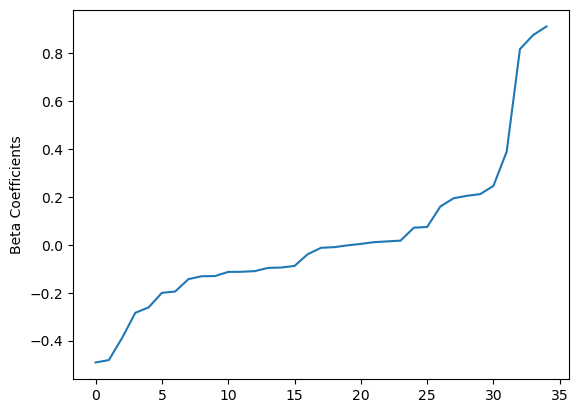

In [14]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

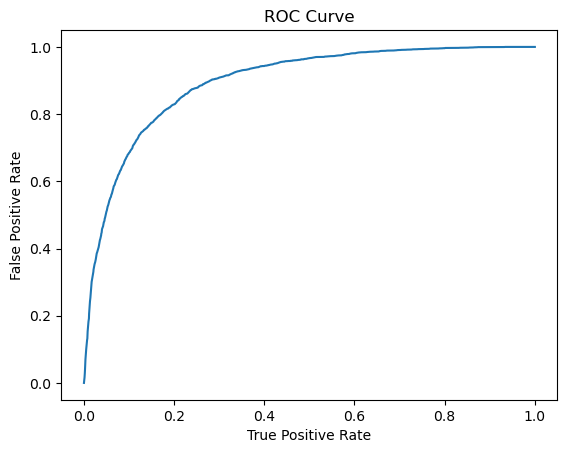

Training set areaUnderROC: 0.8948279136327062


In [15]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

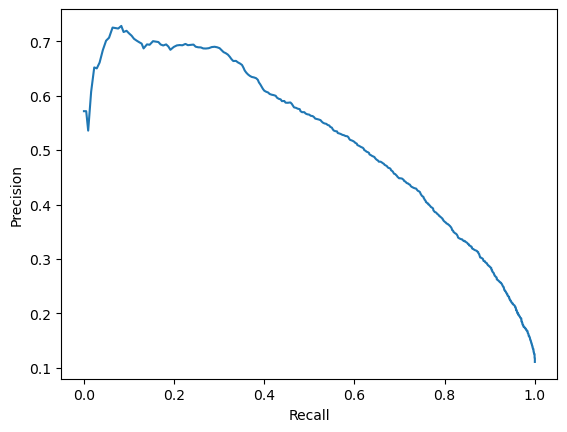

In [16]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

Nastavenie prahu modelu na maximalizáciu F-Measure

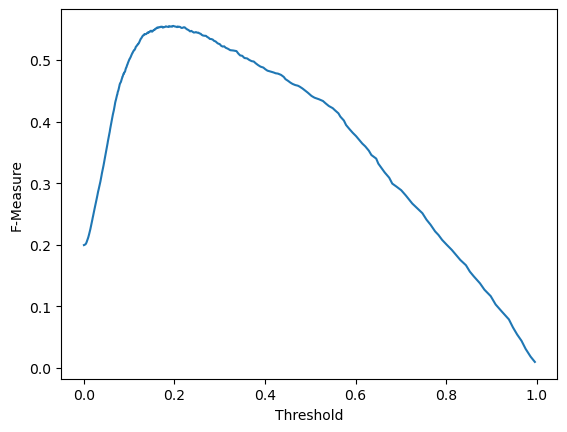

In [17]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

Vytvorenie predikcií na testovacích dátach

In [18]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|  0.0|[1.76328842815219...|       0.0|[0.85362103441128...|
| 27|admin.|  0.0|[2.37638054804607...|       0.0|[0.91500837904636...|
| 28|admin.|  0.0|[1.24815142635926...|       0.0|[0.77697970020207...|
| 29|admin.|  0.0|[3.11177474275100...|       0.0|[0.95737583713479...|
| 29|admin.|  0.0|[3.26846684134536...|       0.0|[0.96333105236901...|
| 29|admin.|  0.0|[2.97744334618952...|       0.0|[0.95154462648543...|
| 29|admin.|  0.0|[2.57678049660215...|       0.0|[0.92935217909035...|
| 30|admin.|  0.0|[5.28916241180646...|       0.0|[0.99497934918087...|
| 30|admin.|  0.0|[3.09088134166150...|       0.0|[0.95651503834018...|
| 30|admin.|  0.0|[2.79985784650566...|       0.0|[0.94266814191088...|
+---+------+-----+--------------------+----------+--------------

Vyhodnotenie modelu Logistickej Regresie

In [19]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8972386836464508


In [20]:
evaluator.getMetricName()

'areaUnderROC'

Hľadanie vhodných parametrov pomocou ParamGridBuilder a krížovej validácie.

In [21]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8986177577773795


In [22]:
evaluator.getMetricName()

'areaUnderROC'

### Rozhodovacie stromy

Rozhodovacie stromy sú široko používané, pretože sú ľahko interpretovateľné, zvládajú kategorické vlastnosti, rozširujú sa na nastavenie klasifikácie viacerých tried, nevyžadujú škálovanie prvkov a sú schopné zachytiť nelinearity a interakcie prvkov.

In [23]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+----------------+----------+--------------------+
|age|   job|label|   rawPrediction|prediction|         probability|
+---+------+-----+----------------+----------+--------------------+
| 24|admin.|  0.0|[23244.0,1197.0]|       0.0|[0.95102491714741...|
| 27|admin.|  0.0|[23244.0,1197.0]|       0.0|[0.95102491714741...|
| 28|admin.|  0.0|  [1148.0,448.0]|       0.0|[0.71929824561403...|
| 29|admin.|  0.0|[23244.0,1197.0]|       0.0|[0.95102491714741...|
| 29|admin.|  0.0|[23244.0,1197.0]|       0.0|[0.95102491714741...|
| 29|admin.|  0.0|[23244.0,1197.0]|       0.0|[0.95102491714741...|
| 29|admin.|  0.0|[23244.0,1197.0]|       0.0|[0.95102491714741...|
| 30|admin.|  0.0|[23244.0,1197.0]|       0.0|[0.95102491714741...|
| 30|admin.|  0.0|[23244.0,1197.0]|       0.0|[0.95102491714741...|
| 30|admin.|  0.0|[23244.0,1197.0]|       0.0|[0.95102491714741...|
+---+------+-----+----------------+----------+--------------------+
only showing top 10 rows



Vyhodnotenie modelu rozhodovacieho stromu

In [24]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.24644852468077022


In [25]:
evaluator.getMetricName()

'areaUnderROC'

Jeden jednoduchý rozhodovací strom nieje veľmi presný, pretože je príliš slabý vzhľadom na rozsah rôznych funkcií. Presnosť predikcie rozhodovacích stromov sa dá zlepšiť metódami Ensemble.

### Klasifikátor Náhodný Les (Random Forest)

In [26]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|  0.0|[17.9282152802610...|       0.0|[0.89641076401305...|
| 27|admin.|  0.0|[18.5132403864964...|       0.0|[0.92566201932482...|
| 28|admin.|  0.0|[15.9832744715496...|       0.0|[0.79916372357748...|
| 29|admin.|  0.0|[18.6754285315245...|       0.0|[0.93377142657622...|
| 29|admin.|  0.0|[18.7320017027243...|       0.0|[0.93660008513621...|
| 29|admin.|  0.0|[18.6754285315245...|       0.0|[0.93377142657622...|
| 29|admin.|  0.0|[18.6754285315245...|       0.0|[0.93377142657622...|
| 30|admin.|  0.0|[18.7320017027243...|       0.0|[0.93660008513621...|
| 30|admin.|  0.0|[18.6754285315245...|       0.0|[0.93377142657622...|
| 30|admin.|  0.0|[18.6754285315245...|       0.0|[0.93377142657622...|
+---+------+-----+--------------------+----------+--------------

In [27]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8808586635411547


In [28]:
evaluator.getMetricName()

'areaUnderROC'

In [29]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

### Gradient-boosted Tree klasifikátor

In [30]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 24|admin.|  0.0|[0.62623352555186...|       0.0|[0.77772662735778...|
| 27|admin.|  0.0|[0.91420307641293...|       0.0|[0.86157174477724...|
| 28|admin.|  0.0|[0.31648858567712...|       0.0|[0.65316421992857...|
| 29|admin.|  0.0|[1.27243732348460...|       0.0|[0.92722843338431...|
| 29|admin.|  0.0|[1.27243732348460...|       0.0|[0.92722843338431...|
| 29|admin.|  0.0|[1.26498040753136...|       0.0|[0.92621567553589...|
| 29|admin.|  0.0|[1.15266732811574...|       0.0|[0.90931789026583...|
| 30|admin.|  0.0|[1.27243732348460...|       0.0|[0.92722843338431...|
| 30|admin.|  0.0|[1.26498040753136...|       0.0|[0.92621567553589...|
| 30|admin.|  0.0|[1.23164250692767...|       0.0|[0.92152754624400...|
+---+------+-----+--------------------+----------+--------------

In [31]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8985131725817315


In [32]:
evaluator.getMetricName()

'areaUnderROC'

Gradient-boosted Tree dosiahol najlepšie výsledky, vyskúšame vyladenie tohto modelu pomocou ParamGridBuilder a CrossValidator. Predtým môžeme použiť explainParams() na zobrazenie zoznamu všetkých parametrov a ich definícií, aby sme pochopili, ktoré parametre sú k dispozícii na ladenie.

In [33]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [34]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.903205765265272